<a href="https://colab.research.google.com/github/raghavendrakulkarni14/BOOK_RECOMMENDATION/blob/main/BOOK_RECOMMENDATION_RaghvendraAKulkarni.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#importing libraries
import numpy as np
import scipy
import pandas as pd
import math
import random
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


In [4]:
# Reading all three datasets
book_df = pd.read_csv('/content/drive/MyDrive/AlmaBetter Recommendation CAP4/Books.csv')
rating_df = pd.read_csv('/content/drive/MyDrive/AlmaBetter Recommendation CAP4/Ratings.csv')
rating_df.columns = ['userID', 'ISBN', 'BookRating']
user_df = pd.read_csv('/content/drive/MyDrive/AlmaBetter Recommendation CAP4/Users.csv')
user_df.columns = ['userID', 'Location', 'Age']


In [5]:
#Looking at book dataset
book_df.head(7)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...
5,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...
6,0425176428,What If?: The World's Foremost Military Histor...,Robert Cowley,2000,Berkley Publishing Group,http://images.amazon.com/images/P/0425176428.0...,http://images.amazon.com/images/P/0425176428.0...,http://images.amazon.com/images/P/0425176428.0...


In [6]:
#Looking at rating dataset
rating_df.head(5)

,userID,ISBN,BookRating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [7]:
##Looking at user dataset
user_df.head(5)

,userID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [6]:
book_df.shape

(271360, 8)

In [7]:
rating_df.shape

(1149780, 3)

In [8]:
user_df.shape

(278858, 3)

##**The dataset has the most  books which have no rating and also the given ratings ratings are quite decent with above 5**

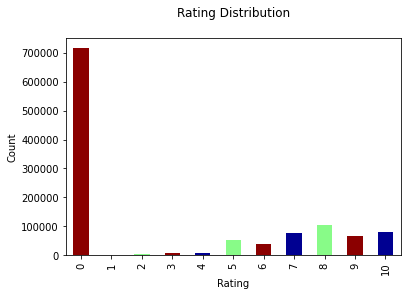

In [26]:
# Bar graph to know the rating distribution
rating_df['BookRating'].value_counts(sort=False).plot(kind='bar',color=['#8B0000','#000091', '#88FB88'])
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

## **The age group of 20-40 years of reader have given most number of ratings**

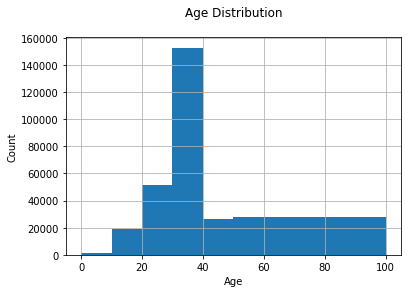

In [31]:
# Histogram to know the age distribution 
# filled nan values with mean
user_df.Age.fillna(user_df.Age.mean()).hist(bins=[0, 10, 20, 30, 40, 50, 100])
plt.title('Age Distribution\n')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()


## **The year 2002 has relatively most number of books published followed by 2001,2000,1999,1998**

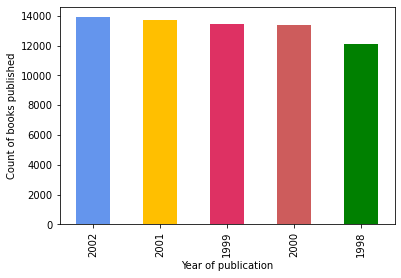

In [11]:
#bar graph of year with most publishes
book_df['Year-Of-Publication'].value_counts().sort_values(ascending=False).head(5).plot(kind='bar',color=[ "#6495ED","#FFBF00","#DE3163","#CD5C5C",'#008000'])
plt.xlabel('Year of publication')
plt.ylabel('Count of books published')
plt.show()


#**Basic recommendation using ratings**

In [12]:
# grouping book rating with ISBN to know which are the most rated books
rating_count = pd.DataFrame(rating_df.groupby('ISBN')['BookRating'].count()).reset_index()
rating_count.sort_values('BookRating', ascending=False).head()

,ISBN,BookRating
247408,0971880107,2502
47371,0316666343,1295
83359,0385504209,883
9637,0060928336,732
41007,0312195516,723


In [13]:
# getting the details of top 5 rated books 
most_rated_books = pd.DataFrame(['0971880107', '0316666343', '0385504209', '0060928336', '0312195516'], index=np.arange(5), columns = ['ISBN'])
most_rated_books_summary = pd.merge(most_rated_books, book_df, on='ISBN')
most_rated_books_summary

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0971880107,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...
1,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown",http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...
2,0385504209,The Da Vinci Code,Dan Brown,2003,Doubleday,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...
3,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997,Perennial,http://images.amazon.com/images/P/0060928336.0...,http://images.amazon.com/images/P/0060928336.0...,http://images.amazon.com/images/P/0060928336.0...
4,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA,http://images.amazon.com/images/P/0312195516.0...,http://images.amazon.com/images/P/0312195516.0...,http://images.amazon.com/images/P/0312195516.0...


# **Top rated book is  Wild Animus with id	0971880107** #




In [14]:
average_rating = pd.DataFrame(rating_df.groupby('ISBN')['BookRating'].mean())
average_rating['ratingCount'] = pd.DataFrame(rating_df.groupby('ISBN')['BookRating'].count())
average_rating.sort_values('ratingCount', ascending=False).head()

,BookRating,ratingCount
ISBN,,
0971880107,1.019584,2502
0316666343,4.468726,1295
0385504209,4.652322,883
0060928336,3.448087,732
0312195516,4.334716,723


# **Recommendation using pearson correlation**

In [15]:
# keeping the users who have given ratings of 200 and books with rating count 100.
counts1 = rating_df['userID'].value_counts()
rating_df = rating_df[rating_df['userID'].isin(counts1[counts1 >= 200].index)]
counts = rating_df['BookRating'].value_counts()
rating_df = rating_df[rating_df['BookRating'].isin(counts[counts >= 100].index)]

In [16]:
# creating pivot matrix
rating_pivot_matrix_df = rating_df.pivot(index='userID',columns='ISBN',values='BookRating').fillna(0)

rating_pivot_matrix_df.head()


ISBN,0330299891,0375404120,0586045007,9022906116,9032803328,9044922564,9044922572,9044922718,9044923161,904492401X,9061002273,*0515128325,+0451197399,0 00 612183 7,0 00 614494 2,0 7336 1053 6,0 907 062 008,0*708880258,0.330241664,00000000,000000000,0000000000,00000000000,000000000000,0000000000000,0000000029841,0000000030670,0000000033220,0000000051,0000001042283,0000001481,0000018030,0000722105029,0000913154,0001010565,0001046438,000104687X,0001047213,0001047639,0001047663,...,O425155404,O42516313X,O439060737,O439161673,O446611638,O451203771,O499139921,O590418262,O590477412,O59052528X,O67174142X,O774037474,O77O428452,O786001690,O805063196,O856856428,O861366301,O880015152,O889950962,O9088446X,PS3569E84K5,Q380708353,Q912838027,SBN67001026X,T110105305048,T110105705048,TBR0385495641,THEALLTRUETRA,THECATASTROPH,THEFLYINGACE,UNGRANDHOMMED,X000000000,"YOUTELLEM,AND",ZR903CX0003,"\0432534220\""""","\2842053052\""""",b00005wz75,cn108465,cn113107,Ô½crosoft
userID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2766,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2977,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3363,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# choosing random book id and checking for the pearson correlation to recommend accordingly
randomBook_ratings = rating_pivot_matrix_df['0000000051']
similar_to_randomBook = rating_pivot_matrix_df.corrwith(randomBook_ratings)
corr_rb = pd.DataFrame(similar_to_randomBook, columns=['pearsonR'])
corr_rb.dropna(inplace=True)
corr_summary = corr_rb.join(average_rating['ratingCount'])
corr_summary[corr_summary['ratingCount']>=300].sort_values('pearsonR', ascending=False).head(10)

,pearsonR,ratingCount
ISBN,,
0446610038,0.190406,391
0385335482,0.152680,350
0743418174,0.125573,470
0316666343,0.111594,1295
0375725784,-0.004257,302
0312291639,-0.004717,354
0684872153,-0.004820,326
0440241073,-0.005056,456
006101351X,-0.005058,364


In [18]:
# getting the correlation with respect to the book id 0000000051 and the recoomended book ids , names and other details
books_corr_to_rb = pd.DataFrame(['0000000051', '0446610038', '0385335482', '0743418174', '0316666343', '0375725784', '0312291639', '0684872153', '0440241073'],index=np.arange(9),columns=['ISBN'])
corr_books = pd.merge(books_corr_to_rb, book_df, on='ISBN')
corr_books

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0446610038,1st to Die: A Novel,James Patterson,2002,Warner Vision,http://images.amazon.com/images/P/0446610038.0...,http://images.amazon.com/images/P/0446610038.0...,http://images.amazon.com/images/P/0446610038.0...
1,0385335482,Confessions of a Shopaholic (Summer Display Op...,SOPHIE KINSELLA,2001,Delta,http://images.amazon.com/images/P/0385335482.0...,http://images.amazon.com/images/P/0385335482.0...,http://images.amazon.com/images/P/0385335482.0...
2,0743418174,Good in Bed,Jennifer Weiner,2002,Washington Square Press,http://images.amazon.com/images/P/0743418174.0...,http://images.amazon.com/images/P/0743418174.0...,http://images.amazon.com/images/P/0743418174.0...
3,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown",http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...
4,0375725784,A Heartbreaking Work of Staggering Genius,Dave Eggers,2001,Vintage Books USA,http://images.amazon.com/images/P/0375725784.0...,http://images.amazon.com/images/P/0375725784.0...,http://images.amazon.com/images/P/0375725784.0...
5,0312291639,The Nanny Diaries: A Novel,Emma McLaughlin,2003,St. Martin's Griffin,http://images.amazon.com/images/P/0312291639.0...,http://images.amazon.com/images/P/0312291639.0...,http://images.amazon.com/images/P/0312291639.0...
6,0684872153,Angela's Ashes (MMP) : A Memoir,Frank McCourt,1999,Scribner,http://images.amazon.com/images/P/0684872153.0...,http://images.amazon.com/images/P/0684872153.0...,http://images.amazon.com/images/P/0684872153.0...
7,0440241073,The Summons,John Grisham,2002,Dell Publishing Company,http://images.amazon.com/images/P/0440241073.0...,http://images.amazon.com/images/P/0440241073.0...,http://images.amazon.com/images/P/0440241073.0...


In [22]:
# merging rating and books dataframe for recommendations
book_rating_df = pd.merge(rating_df, book_df, on='ISBN')
columns = ['Year-Of-Publication', 'Publisher', 'Book-Author','Image-URL-S','Image-URL-M','Image-URL-L']
book_rating_df = book_rating_df.drop(columns, axis=1)
book_rating_df.head()

,userID,ISBN,BookRating,Book-Title
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...


In [27]:
book_ratingCount = (book_rating_df.groupby(by = ['Book-Title'])['BookRating'].count().reset_index().rename(columns = {'BookRating': 'totalRatingCount'})[['Book-Title', 'totalRatingCount']])
book_ratingCount.head()

,Book-Title,totalRatingCount
0,A Light in the Storm: The Civil War Diary of ...,2
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,Beyond IBM: Leadership Marketing and Finance ...,1
4,Clifford Visita El Hospital (Clifford El Gran...,1


In [28]:
rating_with_totalRatingCount = book_rating_df.merge(book_ratingCount, left_on = 'Book-Title', right_on = 'Book-Title', how = 'left')
rating_with_totalRatingCount.head()

,userID,ISBN,BookRating,Book-Title,totalRatingCount
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...,82
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82


In [29]:
popularity_threshold = 50
rating_popular_book = rating_with_totalRatingCount.query('totalRatingCount >= @popularity_threshold')
rating_popular_book.head()

,userID,ISBN,BookRating,Book-Title,totalRatingCount
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...,82
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82


# **SingularValue Decomposition model**

In [52]:
# creating pivot matrix
rating_popular_book = rating_popular_book.drop_duplicates(['userID', 'Book-Title'])
rating_popular_book_pivot = rating_popular_book.pivot(index = 'Book-Title', columns = 'userID', values = 'BookRating').fillna(0)

In [54]:
# The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 15

#Performs matrix factorization of the original user item matrix
U, sigma, Vt = svds(rating_popular_book_matrix, k = NUMBER_OF_FACTORS_MF)


In [55]:
print(rating_popular_book_matrix.shape)
print(U.shape)
print(Vt.shape)
sigma = np.diag(sigma)
sigma.shape

(746, 894)
(746, 15)
(15, 894)


(15, 15)

In [56]:
# dot product of svd
predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
predicted_ratings

array([[ 0.86923293,  0.25331046,  0.08945206, ...,  0.        ,
         0.07814495, -0.09302338],
       [-0.38495866,  0.35593321,  0.0166127 , ...,  0.        ,
         0.35382415,  0.09203943],
       [-0.33656391,  0.97687353, -0.59270844, ...,  0.        ,
         0.31310499,  0.12902058],
       ...,
       [ 0.43184322,  0.098436  ,  0.20066087, ...,  0.        ,
        -0.08338686,  0.2218883 ],
       [ 0.01989917, -0.10589713,  0.0441732 , ...,  0.        ,
         0.11416604,  0.02916494],
       [ 0.06107908,  0.20360699,  0.32025999, ...,  0.        ,
        -0.04401432,  0.03446983]])

In [66]:
# predictions using svd
cf_preds_df = pd.DataFrame(predicted_ratings).transpose()
cf_preds_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745
0,0.869233,-0.384959,-0.336564,0.077490,0.335314,0.206850,-0.149712,0.191202,-0.011794,-0.017031,0.059485,-0.064755,0.328531,-0.084262,0.024279,0.280666,-0.053514,0.097293,0.136216,-0.225206,-0.194610,0.018735,0.557578,0.126409,0.047895,0.391001,0.028854,-0.106500,0.364916,0.901295,1.155767,0.417007,0.222581,-0.074667,0.352038,0.165438,0.041696,-0.306019,0.182039,-0.005190,...,0.274206,-0.005436,-0.057931,0.110723,-0.162946,-0.187734,-0.025691,-0.239623,1.276890,-0.183049,-0.100422,0.213617,0.043544,0.095118,-0.318024,-0.224280,-0.078038,0.199532,0.300539,-0.109003,0.001859,0.227734,-0.032591,-0.017644,0.281076,0.014973,0.642821,-0.243995,0.107516,-0.082170,-0.163138,0.034537,0.187625,0.628119,0.108682,0.045741,-0.136706,0.431843,0.019899,0.061079
1,0.253310,0.355933,0.976874,0.013973,0.080115,0.156538,0.153545,-0.236262,0.132289,-0.130376,0.171380,0.059690,-0.115298,0.154990,0.116677,0.180043,-0.042696,-0.040111,0.186293,-0.029667,0.881945,0.025002,0.340600,-0.003383,0.064187,0.609525,-0.036117,-0.008721,0.016348,0.099362,0.166177,-0.007532,0.127958,0.079117,0.028289,0.220424,0.054880,0.074750,0.434505,0.058198,...,0.261081,0.021061,0.192945,0.219925,0.154056,-0.158086,-0.110971,0.045818,0.228893,0.058322,-0.104707,-0.273658,0.293657,0.156291,-0.011190,0.034590,0.414358,-0.324452,-0.105263,0.023373,-0.192838,0.055974,-0.112069,0.103628,0.003698,-0.015408,-0.016382,0.209183,-0.009547,0.009155,0.206693,0.310060,0.289143,0.422717,0.024570,0.155772,-0.253601,0.098436,-0.105897,0.203607
2,0.089452,0.016613,-0.592708,0.131000,0.527506,0.077626,0.018276,0.558472,0.150181,0.031874,0.016556,0.009468,0.077929,0.169604,0.396194,0.724893,0.050981,0.248388,-0.055066,0.253626,0.606739,0.056356,0.755559,0.169854,0.204687,0.236589,0.258702,0.370583,0.539172,0.311843,0.131693,-0.139172,0.389030,0.010539,0.427326,-0.007696,-0.016379,-0.014185,0.224429,0.001397,...,-0.095514,0.069073,0.480852,0.069797,0.042327,0.167873,0.000814,0.191327,0.353998,0.639926,0.075287,0.183394,0.138336,0.386660,0.395103,0.365748,0.233061,1.655899,0.188731,0.975454,0.094506,-0.051496,0.441759,0.459927,0.442797,0.279495,0.438737,0.130261,0.366971,0.157302,0.351190,0.058006,-0.167553,-0.227033,0.341441,0.723160,0.211284,0.200661,0.044173,0.320260
3,0.281734,0.086731,-0.136636,0.035233,0.067126,0.167958,-0.019360,0.294701,0.009027,-0.027347,-0.033240,-0.005112,0.046186,0.065431,0.135549,0.303819,0.081190,0.200488,-0.031716,0.244324,0.097048,0.000515,0.026757,-0.040263,-0.002456,-0.119453,0.222597,0.202160,0.100807,-0.039254,0.011072,0.025153,0.322446,0.120290,0.072066,0.008180,-0.066414,0.125164,-0.024408,-0.023727,...,0.034084,0.013321,0.192756,0.068283,-0.008320,0.049356,0.020815,0.055388,0.441345,0.220042,-0.136118,-0.110659,0.022339,0.023538,0.134101,0.122492,0.277568,0.402164,0.032304,0.306205,-0.125916,-0.017172,0.105232,0.508872,0.015052,0.068703,0.025697,0.013005,0.084595,-0.102085,0.214394,0.033211,-0.043679,-0.038576,0.063007,0.173887,-0.158954,0.049210,0.075052,0.066485
4,-0.024191,0.120967,-0.204837,0.020540,0.137910,0.043033,0.059342,0.260697,0.024889,0.023094,-0.047537,0.052085,-0.016868,-0.014482,0.077758,0.052382,0.105032,0.185479,0.033406,0.107536,0.316868,0.068904,0.173903,-0.032551,0.062070,0.300557,0.094709,0.187459,0.060702,0.134003,0.061650,-0.041794,0.118860,0.029964,0.017748,-0.025892,-0.025456,0.077336,0.042183,0.056604,...,-0.034005,0.025413,-0.178482,-0.007000,0.066026,0.209106,0.045995,0.130455,-0.097525,0.247608,0.022706,0.114894,-0.036031,0.075556,0.160114,0.010192,0.036275,0.724816,0.075739,0.186985,0.033145,0.002642,0.127239,0.135451,0.055847,-0.007831,0.010572,0.126017,0.096301,0.056886,-0.015510,0.008084,-0.022891,-0.127032,0.003154,0.150145,0.089029,-0.035551,0.0939

# **NEAREST NEIGHBORS MODEL** #

In [48]:
# create pivot table and sparse matrix
from scipy.sparse import csr_matrix
rating_popular_book = rating_popular_book.drop_duplicates(['userID', 'Book-Title'])
rating_popular_book_pivot = rating_popular_book.pivot(index = 'Book-Title', columns = 'userID', values = 'BookRating').fillna(0)
rating_popular_book_matrix = csr_matrix(rating_popular_book_pivot.values)


In [39]:
# create recommendation model using nearest neigbors library from sklearn
from sklearn.neighbors import NearestNeighbors


model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(rating_popular_book_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [32]:
# getting random index for recommendation 
query_index = np.random.choice(rating_popular_book_pivot.shape[0])
print(query_index)

410


In [34]:
# getting the distances and indices of the recommended books
distances, indices = model_knn.kneighbors(rating_popular_book_pivot.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 6)

In [35]:
# the random index book name
rating_popular_book_pivot.index[query_index]

'Q Is for Quarry'

In [38]:
# six recommendations for the book Q Is for Quarry
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(rating_popular_book_pivot.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, rating_popular_book_pivot.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for Q Is for Quarry:

1: \O\" Is for Outlaw", with distance of 0.6322893222327075:
2: Last Man Standing, with distance of 0.6700596497351383:
3: The Face of Deception, with distance of 0.708976117710828:
4: D Is for Deadbeat (Kinsey Millhone Mysteries (Paperback)), with distance of 0.7360139348141101:
5: P Is for Peril, with distance of 0.7447686746937938:


#*The recommended books from the book 'Q Is for Quarry'are*#
#*1: \O\" Is for Outlaw", with distance of 0.6322893222327075:*#
#*2: Last Man Standing, with distance of 0.6700596497351383:*#

#*3: The Face of Deception, with distance of 0.708976117710828:*#

#*4: D Is for Deadbeat (Kinsey Millhone Mysteries (Paperback)), with distance of 0.7360139348141101:*#

#*5: P Is for Peril, with distance of 0.7447686746937938:*#